# Filter generated linkers and get 2D metrics
* generative metrics
    * validity
    * uniqueness
    * novelty (to PROTAC-DB)
    * Recovery (to PROTAC-DB)
    * max Tanimoto (to reference linker)
* chemistry metrics
    * QED
    * SA
    * passing 2D filters
        * PAINS
        * ring aromaticity (RA): rings must either be sat. aliphatic or aromatic
    * num rings
    * num rotatable bonds

In [3]:
import glob
import os
import rdkit
from rdkit import Chem, RDLogger, DataStructs, RDConfig
from rdkit.Chem import PandasTools, rdRGroupDecomposition, QED, rdFMCS
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
import pandas as pd
import numpy as np
import sys
import copy
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from data_postprocessing import is_good_linker, get_linker_new
from utils.chem_transforms import generate_ext_linker, set_stereo2query

In [2]:
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

## Load Data

In [3]:
pdb = '7JTO'
method = 'shape'

### generated data

In [4]:
gen_folder = 'data/generated'
df = pd.read_csv(os.path.join(gen_folder, f'{pdb}_sampled_{method}.csv'))
df.head()

,molecules,input,linker,likelihood
0,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)O...,C(NCc1ccc(-c2scnc2C)cc1)(C1CC(O)CN1C(C(C(C)(C)...,[*]OC1COCN(CCO[*])C(=O)C1,15.048829
1,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)O...,C(NCc1ccc(-c2scnc2C)cc1)(C1CC(O)CN1C(C(C(C)(C)...,N(C(=O)OCO[*])C(CC[*])=O,15.131113
2,INVALID,C(NCc1ccc(-c2scnc2C)cc1)(C1CC(O)CN1C(C(C(C)(C)...,c1c(NN=N[*])cc(-c2cn3c([*])coc3nc2)cc1,32.549419
3,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)O...,C(NCc1ccc(-c2scnc2C)cc1)(C1CC(O)CN1C(C(C(C)(C)...,Oc1c(CO[*])cnc(OCC[*])c1,13.780678
4,Cc1ncsc1-c1ccc(CNC(=O)C2CC(O)CN2C(=O)C(NC(=O)O...,C(NCc1ccc(-c2scnc2C)cc1)(C1CC(O)CN1C(C(C(C)(C)...,[*]OC1CN(C=NC(=O)NC[*])CC1,18.532667


### original data from xtal poses

In [5]:
xtal_folder = 'data/xtal_poses'
pdb_folder = os.path.join(xtal_folder, pdb)
df_ori = pd.read_csv(os.path.join(xtal_folder, 'protac_systems_012323_linkgen.csv'))
df_ori = df_ori[df_ori['PDB'] == pdb]
df_ori

,PDB,protac_smiles,linker_smiles,linker_ext_smiles,anchor_smiles,warhead_smiles,POI,E3,protacdb_ID,name,frag_combined,linker_ev,anchor_ev,warhead_ev
0,7JTO,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,CCCCCCCCCC(=O)NCC,NC(=O)CCCCCCCCCC(=O)NCCN1CCNCC1,Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,CN1CCN(c2ccc(-c3cccc(CN4CCNCC4)c3)cc2NC(=O)C2=...,WDR5,VHL,3245.0,MS33,*C(=O)N[C@H](C(=O)N1C[C@H](O)C[C@H]1C(=O)NCc1c...,O=C(CCCCCCCCC[*:1])NCC[*:2],Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,CN1CCN(c2ccc(-c3cccc(CN4CCN([*:2])CC4)c3)cc2NC...


### reference data (PROTAC-DB)

In [6]:
df_ref = pd.read_csv('data/protacdb_extended_linkers.csv')
df_ref.head()

,protac_id,Uniprot,Target,E3 ligase,PDB,Name,protac_smiles,anchor_smiles,warhead_smiles,linker_smiles,linker_id,Smiles,InChI,ext_linker_smiles
0,1,Q9NPI1;Q9H8M2,BRD7;BRD9,VHL,NaN,NaN,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,*C(=O)N[C@H](C(=O)N1C[C@@H](C[C@H]1C(=O)NCC2=C...,*N1CCN(CC1)CC2=C(C=C(C=C2OC)C3=CN(C(=O)C4=C3C=...,CCOCCOC,1.0,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,InChI=1S/C50H64N8O9S/c1-32-45(68-31-53-32)34-1...,NC(=O)COCCOCCN1CCNCC1
1,2,Q9NPI1;Q9H8M2,BRD7;BRD9,VHL,NaN,NaN,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,*C(=O)N[C@H](C(=O)N1C[C@@H](C[C@H]1C(=O)NCC2=C...,*N1CCN(CC1)CC2=C(C=C(C=C2OC)C3=CN(C(=O)C4=C3C=...,CCOCCOCCOCCOC,2.0,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,InChI=1S/C54H72N8O11S/c1-36-49(74-35-57-36)38-...,NC(=O)COCCOCCOCCOCCN1CCNCC1
2,3,Q9H8M2,BRD9,CRBN,NaN,NaN,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,*NC1=CC=CC2=C1C(=O)N(C2=O)C3CCC(=O)NC3=O,*N1CCN(CC1)CC2=C(C=C(C=C2OC)C3=CN(C(=O)C4=C3C=...,CCNC(=O)COCCOCC,3.0,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,InChI=1S/C43H50N8O10/c1-48-24-31(28-9-10-44-23...,O=C(COCCOCCN1CCNCC1)NCCNc1cccc2c1C(=O)NC2=O
3,4,Q9H8M2,BRD9,CRBN,NaN,NaN,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,*NC1=CC=CC2=C1C(=O)N(C2=O)C3CCC(=O)NC3=O,*N1CCN(CC1)CC2=C(C=C(C=C2OC)C3=CN(C(=O)C4=C3C=...,CCNC(=O)COCCOCCOCCOCC,4.0,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,InChI=1S/C47H58N8O12/c1-52-28-35(32-9-10-48-27...,O=C(COCCOCCOCCOCCN1CCNCC1)NCCNc1cccc2c1C(=O)NC2=O
4,5,Q9NPI1;Q9H8M2,BRD7;BRD9,DCAF15,NaN,NaN,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,*NCC1=CC=C(C=C1)S(=O)(=O)NC2=CC=CC3=C2NC=C3Cl,*N1CCN(CC1)CC2=C(C=C(C=C2OC)C3=CN(C(=O)C4=C3C=...,CCOCCOCC=O,5.0,COC1=CC(C2=CN(C)C(=O)C3=CN=CC=C23)=CC(OC)=C1CN...,InChI=1S/C43H48ClN7O8S/c1-49-26-35(32-11-12-45...,CNC(=O)COCCOCCN1CCNCC1


In [7]:
ref_ext_linker_smiles = df_ref['ext_linker_smiles'].unique().tolist()
ref_ext_linker_smiles = [Chem.CanonSmiles(smi) for smi in ref_ext_linker_smiles]
ref_ext_linker_smiles = list(set(ref_ext_linker_smiles))
ref_ext_linker_smiles_noniso = [Chem.MolToSmiles(Chem.MolFromSmiles(smi), isomericSmiles=False) for smi in ref_ext_linker_smiles]
ref_linker_smiles = df_ref['linker_smiles'].unique().tolist()
# drop nan
ref_linker_smiles = [smi for smi in ref_linker_smiles if type(smi) == str]
ref_linker_smiles = [Chem.CanonSmiles(smi) for smi in ref_linker_smiles]
ref_linker_smiles = list(set(ref_linker_smiles))
ref_linker_smiles_noniso = [Chem.MolToSmiles(Chem.MolFromSmiles(smi), isomericSmiles=False) for smi in ref_linker_smiles]
ref_protac_smiles = df_ref['protac_smiles'].unique().tolist()
ref_protac_smiles = [Chem.CanonSmiles(smi) for smi in ref_protac_smiles]
ref_protac_smiles = list(set(ref_protac_smiles))
ref_protac_smiles_noniso = [Chem.MolToSmiles(Chem.MolFromSmiles(smi), isomericSmiles=False) for smi in ref_protac_smiles]

## Format data

In [8]:
# validity
df_valid = df[df['molecules'] != 'INVALID']
df_valid.reset_index(drop=True, inplace=True)
validity = len(df_valid)/len(df)*100
print(f'validity: {validity:.4f}%')

validity: 89.9000%


In [9]:
df_valid.loc[:,'reference'] = pdb
for i, row in df_valid.iterrows():
    df_valid.loc[i, 'ID'] = f'{pdb}_{method}_{i}'

/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/80876716.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid.loc[:,'reference'] = pdb
/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/80876716.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid.loc[i, 'ID'] = f'{pdb}_{method}_{i}'


In [10]:
df_valid.rename(columns={'molecules': 'protac_smiles',
        'linker': 'linker_ev'}, inplace=True)
# get anchor smiles from df_ori
df_valid.loc[:,'anchor_smiles'] = df_ori['anchor_smiles'].values[0]
df_valid.loc[:,'warhead_smiles'] = df_ori['warhead_smiles'].values[0]
df_valid.loc[:,'anchor_ev'] = df_ori['anchor_ev'].values[0].replace('[*:1]', '*')
df_valid.loc[:,'warhead_ev'] = df_ori['warhead_ev'].values[0].replace('[*:2]', '*')
PandasTools.AddMoleculeColumnToFrame(df_valid, smilesCol='protac_smiles', molCol='ROMol') 

/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/1954260243.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid.rename(columns={'molecules': 'protac_smiles',
/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/1954260243.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid.loc[:,'anchor_smiles'] = df_ori['anchor_smiles'].values[0]
/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/1954260243.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [11]:
def neutralizeRadicals(mol):
     for a in mol.GetAtoms():
        if a.GetNumRadicalElectrons() > 0:
            a.SetNumRadicalElectrons(0)
            if a.GetFormalCharge() != 0:
                a.SetFormalCharge(0)

for i, row in df_valid.iterrows():
    neutralizeRadicals(row['ROMol'])
    df_valid.loc[i, 'protac_smiles'] = Chem.MolToSmiles(row['ROMol'])
    try:
        linker_mol = Chem.MolFromSmiles(row['linker_ev'])
        neutralizeRadicals(linker_mol)
        df_valid.loc[i, 'linker_ev'] = Chem.MolToSmiles(linker_mol)
    except:
        print(i, row['linker_ev'])

### Extract linker and extended linker

In [13]:
df_valid.loc[:,'linker_mol'] = df_valid.apply(lambda x: get_linker_new(x.ROMol, x.warhead_smiles, x.anchor_smiles), axis=1)

/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/3314701130.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid.loc[:,'linker_mol'] = df_valid.apply(lambda x: get_linker_new(x.ROMol, x.warhead_smiles, x.anchor_smiles), axis=1)


In [14]:
df_valid.loc[:,'linker_smiles'] = df_valid.linker_mol.apply(Chem.MolToSmiles)

/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/988968676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid.loc[:,'linker_smiles'] = df_valid.linker_mol.apply(Chem.MolToSmiles)


In [15]:
df_valid[['extended_linker_smiles']] = df_valid.apply(lambda row: generate_ext_linker(row['protac_smiles'], row['anchor_smiles'], row['warhead_smiles'], return_pd_series=True), axis = 1)

/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/1889910964.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid[['extended_linker_smiles']] = df_valid.apply(lambda row: generate_ext_linker(row['protac_smiles'], row['anchor_smiles'], row['warhead_smiles'], return_pd_series=True), axis = 1)


### Add info from input data

In [16]:
df_valid['POI'] = df_ori.POI.values[0]
df_valid['E3'] = df_ori.E3.values[0]

/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/3741629298.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['POI'] = df_ori.POI.values[0]
/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/3741629298.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['E3'] = df_ori.E3.values[0]


#### assign respective stereochemsitry

In [17]:
def get_ori_stereo(protac, stereo_anchor, stereo_warhead):
    protac = Chem.MolFromSmiles(protac)
    stereo_anchor = Chem.MolFromSmiles(stereo_anchor)
    stereo_warhead = Chem.MolFromSmiles(stereo_warhead)
    protac = set_stereo2query(protac, stereo_anchor)
    protac = set_stereo2query(protac, stereo_warhead)
    return Chem.MolToSmiles(protac)

In [18]:
# add protac with stereochemistry to dataframe
df_valid.loc[:,'protac_smiles'] = df_valid.apply(lambda x: get_ori_stereo(x.protac_smiles, x.anchor_smiles, x.warhead_smiles), axis=1)

/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/2894483890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid.loc[:,'protac_smiles'] = df_valid.apply(lambda x: get_ori_stereo(x.protac_smiles, x.anchor_smiles, x.warhead_smiles), axis=1)


## Get generative metrics

In [19]:
uniqueness = len(df_valid['protac_smiles'].unique())/len(df_valid)*100
print(f'uniqueness: {uniqueness:.4f}%')

uniqueness: 98.6429%


In [20]:
# novelty to PROTAC-DB (on PROTAC level)
gen_protac_noniso = [Chem.MolToSmiles(Chem.MolFromSmiles(smi), isomericSmiles=False) for smi in df_valid['protac_smiles']]
novelty = len(set(gen_protac_noniso) - set(ref_protac_smiles_noniso))/len(set(set(gen_protac_noniso)))*100
print(f'novelty PROTAC: {novelty:.4f}%')

novelty PROTAC: 100.0000%


In [21]:
# max tanimoto similarity to reference linker
df_valid.loc[:,'fp'] = df_valid.linker_mol.apply(Chem.RDKFingerprint)
ori_linker_mol = Chem.MolFromMolFile(os.path.join(pdb_folder, f'{pdb}_fragments',f'{pdb}_linker.sdf'))
ori_linker_fp = Chem.RDKFingerprint(ori_linker_mol)
df_valid.loc[:,'tanimoto'] = df_valid.fp.apply(DataStructs.FingerprintSimilarity, args=(ori_linker_fp,))
print(f'max tanimoto similarity to reference linker: {df_valid.tanimoto.max():.4f}')

max tanimoto similarity to reference linker: 0.4973


/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/2905945115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid.loc[:,'fp'] = df_valid.linker_mol.apply(Chem.RDKFingerprint)
/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/2905945115.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid.loc[:,'tanimoto'] = df_valid.fp.apply(DataStructs.FingerprintSimilarity, args=(ori_linker_fp,))


In [22]:
# check if reference linker is recovered
Chem.MolToSmiles(ori_linker_mol, isomericSmiles=False) in df_valid.linker_smiles.values

False

## Get chemistry metrics

In [23]:
PandasTools.AddMoleculeColumnToFrame(df_valid, 'linker_smiles', 'linker_mol')

/opt/anaconda3/envs/general_env/lib/python3.10/site-packages/rdkit/Chem/PandasTools.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


In [24]:
# average QED
df_valid['qed_protac'] = df_valid.ROMol.apply(QED.qed)
df_valid['qed_linker'] = df_valid.linker_mol.apply(QED.qed)
print(f'average QED of PROTAC: {df_valid.qed_protac.mean():.4f}')
print(f'average QED of linker: {df_valid.qed_linker.mean():.4f}')

/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/362532341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['qed_protac'] = df_valid.ROMol.apply(QED.qed)


average QED of PROTAC: 0.0685
average QED of linker: 0.5736


/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/362532341.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['qed_linker'] = df_valid.linker_mol.apply(QED.qed)


In [25]:
# average SA score
df_valid['sa_protac'] = df_valid.ROMol.apply(sascorer.calculateScore)
df_valid['sa_linker'] = df_valid.linker_mol.apply(sascorer.calculateScore)
# df_valid['sa_linker'] = df_valid.linker_smiles.apply(lambda x:sascorer.calculateScore(Chem.MolFromSmiles(x)))
print(f'average SA score of PROTAC: {df_valid.sa_protac.mean():.4f}')
print(f'average SA score of linker: {df_valid.sa_linker.mean():.4f}')

/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/1621161771.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['sa_protac'] = df_valid.ROMol.apply(sascorer.calculateScore)


average SA score of PROTAC: 5.6589
average SA score of linker: 3.2974


/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/1621161771.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['sa_linker'] = df_valid.linker_mol.apply(sascorer.calculateScore)


In [26]:
# PAINS filters (True if has match)
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)
df_valid['PAINS'] = df_valid.ROMol.apply(lambda x: catalog.HasMatch(x))
print(f'number of PAINS: {df_valid.PAINS.sum()}')

number of PAINS: 81


/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/665005792.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['PAINS'] = df_valid.ROMol.apply(lambda x: catalog.HasMatch(x))


In [27]:
# RA filter
# taken from 3DLinker repo: https://github.com/YinanHuang/3DLinker/blob/b8f5c9207df2d48c6299ea2f7c610b6dcfd6bbf4/analysis/frag_utils.py#L692-L705
def ring_check_for_filter(linker):
    check = True
    # Get linker rings
    ssr = Chem.GetSymmSSSR(linker)
    # Check rings
    for ring in ssr:
        for atom_idx in ring:
            for bond in linker.GetAtomWithIdx(atom_idx).GetBonds():
                if bond.GetBondType() == 2 and bond.GetBeginAtomIdx() in ring and bond.GetEndAtomIdx() in ring:
                    check = False
    return check

In [28]:
# RA filter: True if passes filter
df_valid.loc[:,'ring_arom'] = df_valid.linker_mol.apply(ring_check_for_filter)
print(f'number of RA fails: {len(df_valid) - df_valid.ring_arom.sum()}')

number of RA fails: 430


/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/1905208495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid.loc[:,'ring_arom'] = df_valid.linker_mol.apply(ring_check_for_filter)


In [29]:
# num rings
df_valid['num_rings_linker'] = df_valid.linker_mol.apply(Chem.rdMolDescriptors.CalcNumRings)
# num rotatable bonds
df_valid['num_rot_bonds_linker'] = df_valid.linker_mol.apply(Chem.rdMolDescriptors.CalcNumRotatableBonds)
# check if branched
df_valid['branched'] = df_valid.apply(lambda x: is_good_linker(x['ROMol'], x['warhead_ev'], x['anchor_ev']), axis=1)

/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/974905288.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['num_rings_linker'] = df_valid.linker_mol.apply(Chem.rdMolDescriptors.CalcNumRings)
/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/974905288.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['num_rot_bonds_linker'] = df_valid.linker_mol.apply(Chem.rdMolDescriptors.CalcNumRotatableBonds)
/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_

In [30]:
# filter out PAINS (True) and RA fails (False)
df_valid.loc[:,'reference'] = pdb
df_valid_fil = df_valid[(~df_valid.PAINS) & df_valid.ring_arom]
# ratio that passed filters
print(f'ratio that passed filters: {len(df_valid_fil)/len(df_valid)*100:.4f}%')
print(f'average number of rings in linker: {df_valid.num_rings_linker.mean():.4f}')
print(f'average number of rotatable bonds in linker: {df_valid.num_rot_bonds_linker.mean():.4f}')
print(f'Fraction of branched linkers: {df_valid["branched"].sum()/len(df_valid):.4%}')

ratio that passed filters: 88.6763%
average number of rings in linker: 1.1802
average number of rotatable bonds in linker: 2.2541
Fraction of branched linkers: 4.8498%


/var/folders/zy/1547096d2zgd9gknmbv1ndk40000gn/T/ipykernel_92524/2889861978.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid.loc[:,'reference'] = pdb


## Clean up and save dataframe

In [31]:
df_valid.columns

Index(['protac_smiles', 'input', 'linker_ev', 'likelihood', 'reference', 'ID',
       'anchor_smiles', 'warhead_smiles', 'anchor_ev', 'warhead_ev', 'ROMol',
       'linker_mol', 'linker_smiles', 'extended_linker_smiles', 'POI', 'E3',
       'fp', 'tanimoto', 'qed_protac', 'qed_linker', 'sa_protac', 'sa_linker',
       'PAINS', 'ring_arom', 'num_rings_linker', 'num_rot_bonds_linker',
       'branched'],
      dtype='object')

In [32]:
keep_cols = ['ID', 'reference', 'protac_smiles', 'linker_smiles', 'extended_linker_smiles', 'anchor_smiles', 'warhead_smiles', 'anchor_ev', 'warhead_ev', 'POI', 'E3', 'tanimoto', 'qed_linker', 'sa_linker', 'num_rings_linker', 'num_rot_bonds_linker', 'branched', 'PAINS', 'ring_arom']
keep_cols_fil = [col for col in keep_cols if col not in ['PAINS', 'ring_arom']]
df_valid[keep_cols].to_csv(os.path.join(gen_folder, f'{pdb}_sampled_{method}_valid.csv'), index=False)

## Visualize outputs

In [33]:
mols = []
for i, row in df_valid_fil.iterrows():
    protac = Chem.MolFromSmiles(row.protac_smiles)
    linker = Chem.MolFromSmiles(row.linker_smiles)
    anchor = Chem.MolFromSmiles(row.anchor_smiles)
    warhead = Chem.MolFromSmiles(row.warhead_smiles)
    mols.append(protac)
    mols.append(linker)
    mols.append(anchor)
    mols.append(warhead)

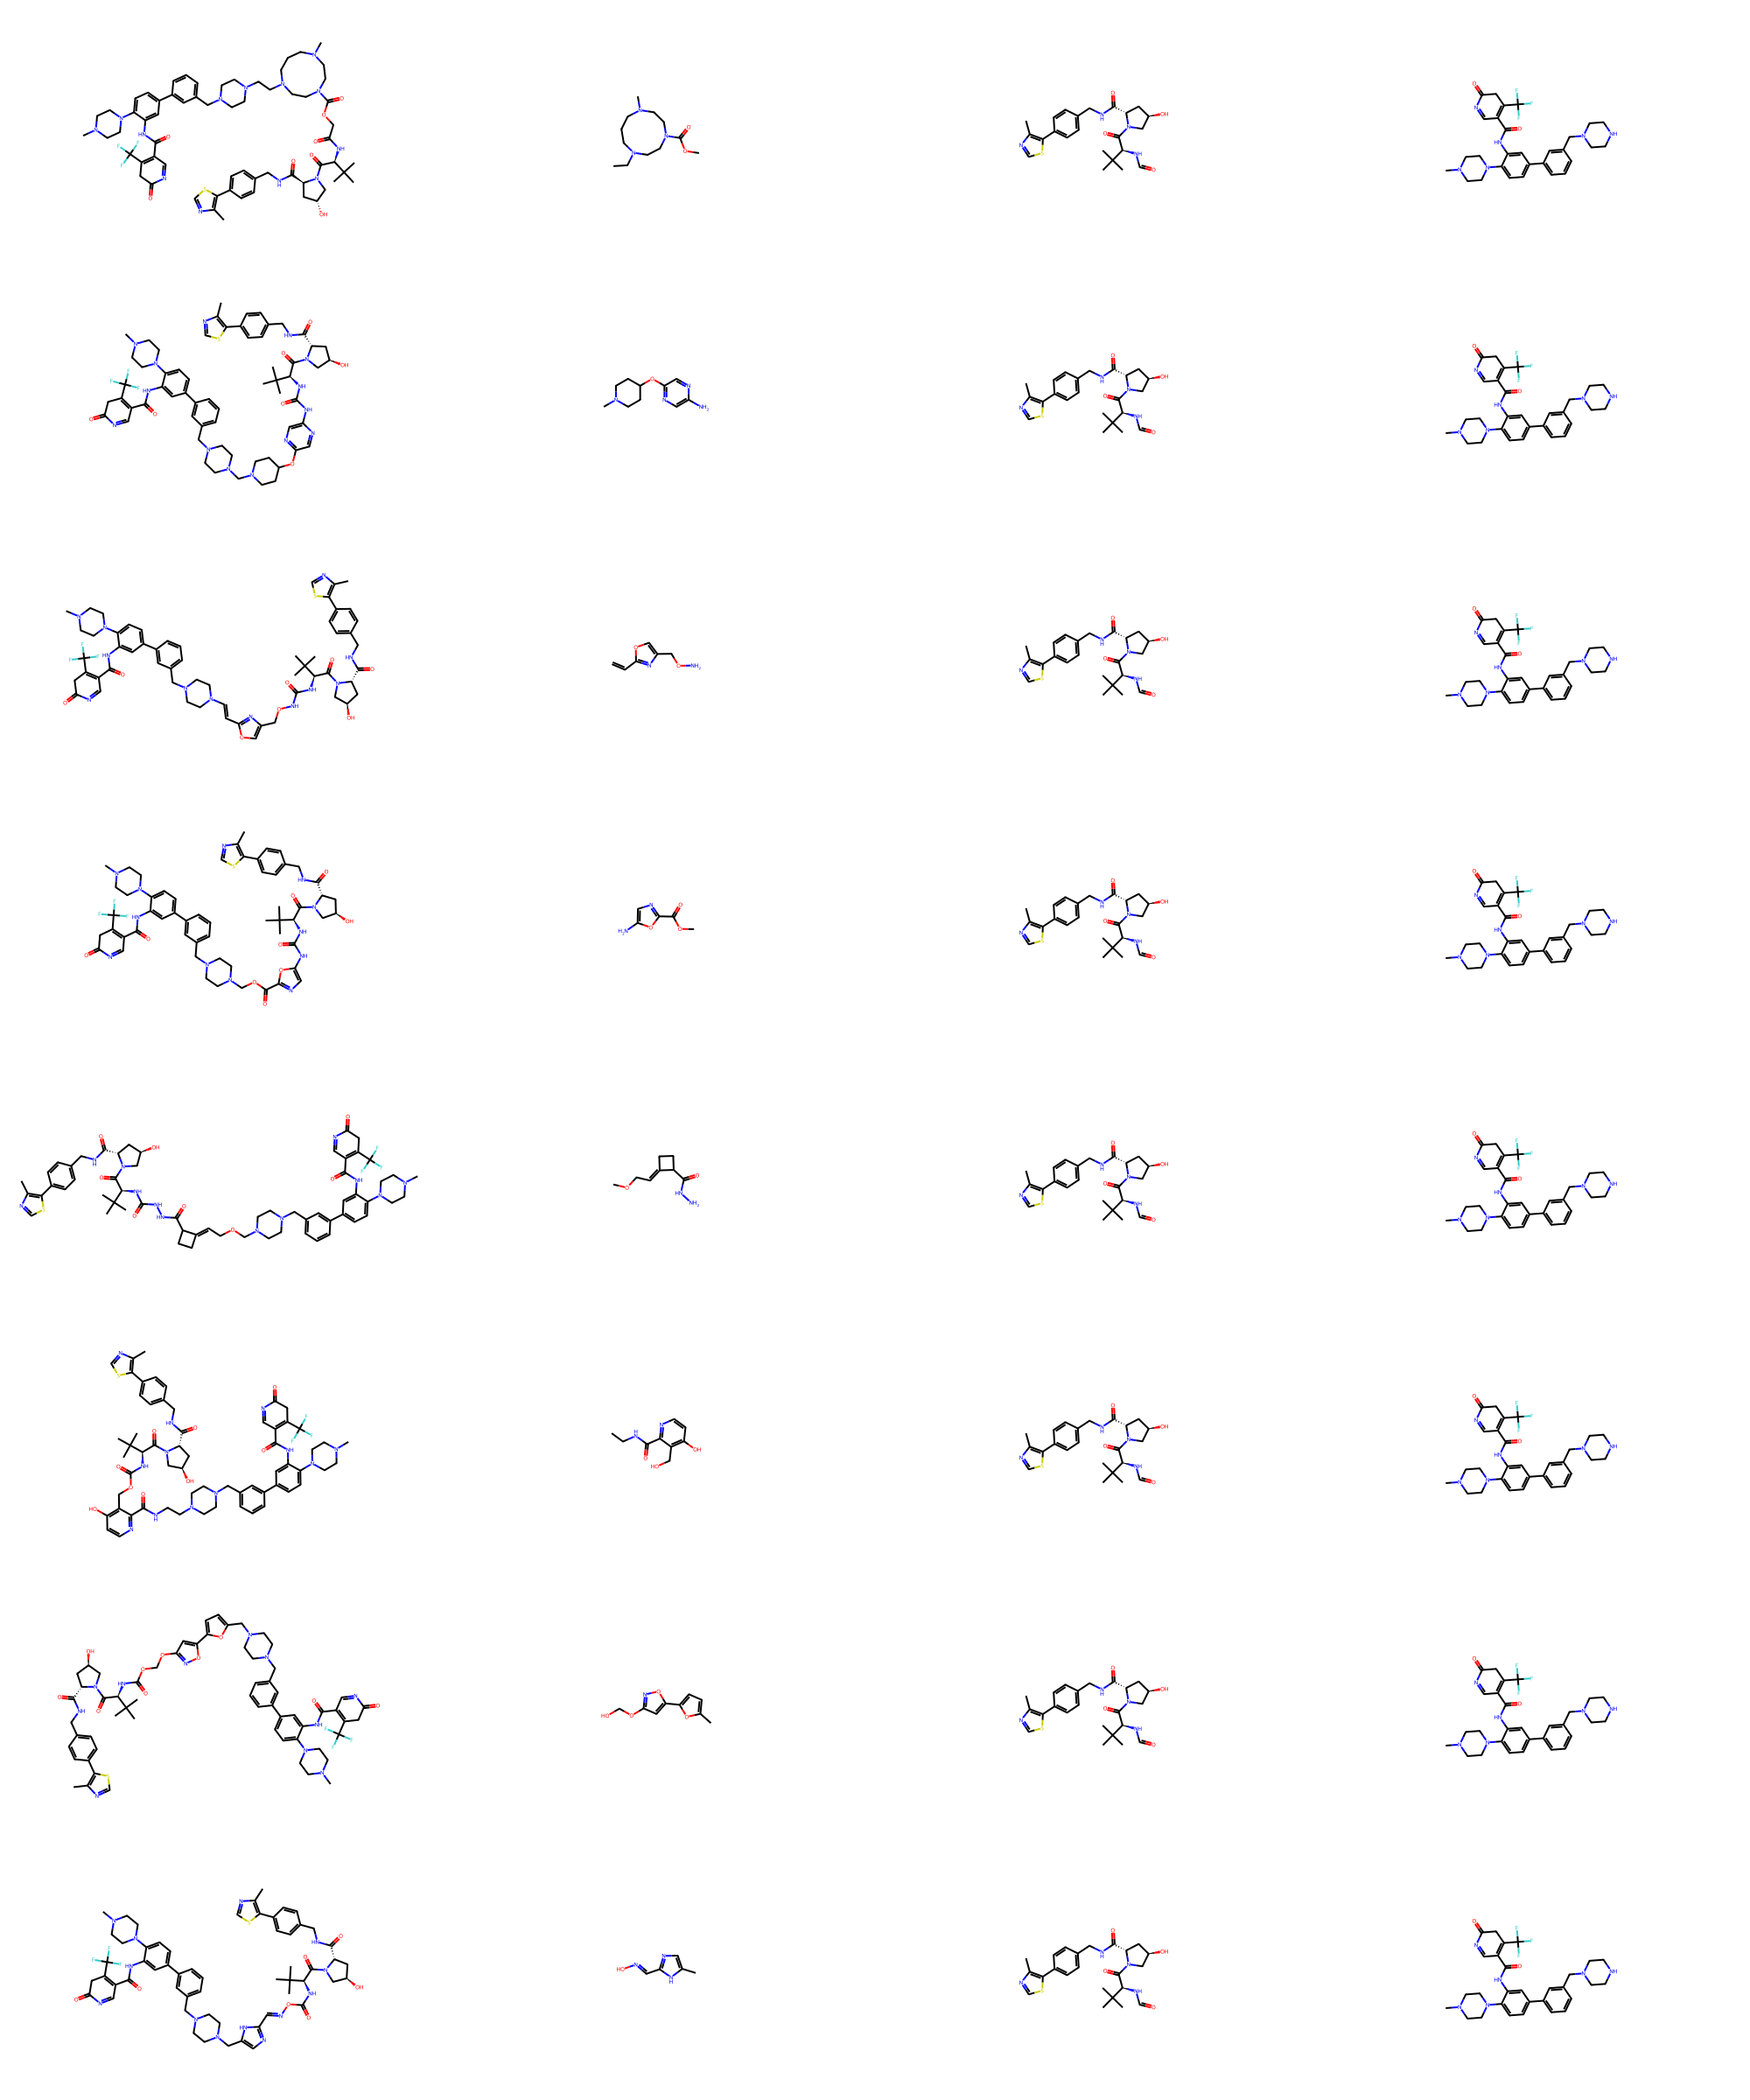

In [34]:
Chem.Draw.MolsToGridImage(mols[48:80], molsPerRow=4, subImgSize=(500,300))